# Imports


In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib
import random
import sys
import os
import re

from rapidfuzz import fuzz
from rapidfuzz.distance import Levenshtein
import unicodedata

from ann_levenshtein import LevenshteinIndex

# Load Data


In [2]:
data = pd.read_csv('Data/IMK품목마스터.txt', delimiter='\t', dtype=str)
data.head(2)

,품목코드,SG코드,SG명,담당자ID,분류체계코드,분류체계명,영문품명,한글품명,규격,모델명,제조원코드,제조원명,단위
0,1000000800,SG30050,청소용품,Z0202542,C1076800,살충제,Fly Swatter,파리채,L520mm,NaN,80036596.0,시중품,PC
1,1000002100,SG30070,세제,Z0202542,C1076800,살충제,Insecticide,살충제,"500ml, 수성에어졸, 무향, 파리/모기등의살충제, 안전기준 확인",홈키파,80031867.0,한국크로락스,PC


In [3]:
data.shape

(2538466, 13)

In [5]:
# data['description'] = data[['영문품명', '한글품명', '규격', '모델명', '제조원명']].astype(str).agg(" ".join, axis=1)
data['description'] = data[['한글품명']].astype(str)
data['label'] = data['품목코드']

In [6]:
data = data[['label', 'description']]

# Preprocess


In [7]:
def preprocessing(text):
    def remove_dup(t):
        sp_str = t.split()
        return " ".join(sorted(set(sp_str), key=sp_str.index))

    if not isinstance(text, str):
        text = str(text)
    
    # text = text.lower()  # 소문자로 변환

    # 패턴 제거: (주), (유)
    text = re.sub(r'\(주\)|\(유\)', '', text)

    # 특수문자 제거 (온점, 쉼표, 물결표 제외)
    special_chars = r'[()\[\]/#φΦØø￠★@%※□:;"＇，_\-!&+=≥±`\'\"←→↑↓↔↕\\\^]'
    text = re.sub(special_chars, ' ', text)

    # 숫자 사이에 있는 .(소숫점 표시) ,(천의 자리 표시), ~(범위 표시)는 유지, 나머지 .,~ 삭제
    text = re.sub(r'(?<!\d)[.,~]|[.,~](?!\d)', ' ', text)

    # 숫자 사이의 ~만 유지
    text = re.sub(r'\s*~\s*', '~', text)  # ~ 앞뒤의 공백 삭제 (ex. 10~100, 10 ~ 100 둘 다 가능하게)
    text = re.sub(r'(?<!\d)~|~(?!\d)', ' ', text)  # ~ 앞뒤가 숫자가 아니면 삭제


    # 불필요 문구 제거 (공통 패턴)
    common_patterns = [
        '세부구성 이미지\s?참고','첨부\s?이미지\s?참고','이미지\s?참조','요청사항\s?참조','명판\s?참조','물류이용불가 품목',
        '일반화물택배발송','주문수입품목으로 교환\s?반품\s?불가','주문제작품으로 교환\s?반품\s?불가','교환 및 반품\s?불가',
        '규격\s?참조','첨부\s?참조','규격\s?참고','도면\s?참조','사양서\s?참조','주문시\s?사이즈\s?기재','추가발주불가',
        '재고\s?문의\s?주세요','주문전\s?재고\s?확인\s?바랍니다','첨부파일 참조','참조s?제작s?할s?것','교환\s?반품\s?불가',
        '도면rev \d+참조','도묜참조','구매\s?시방서참조','구매시방참조','사진s?참고','사양서s?참고','사영서s?참고',
        '도면\s?참고','사양\s?참고','상세정보 첨부참고','상세정보\s?참고','첨부 참고'
    ]
    text = re.sub(r'|'.join(common_patterns), "", text)
    
    # 재고 관련 문구 제거
    inventory_patterns = [
        r"재고 없을\s?시 \d+일\s?소요", r"재고 미보유시 \d+일\s?소요", r'재고\s?소진\s?시 납기 \d+일',
        r'재고 소진\s?시 공급\s?불가', r'재고 소진\s?시 납품\s?불가', r'재고 소진\s?시 공급\s?불가\s?상품',
        r'재고 소진\s?시 \d+일 소요', r'국내 재고 소진\s?시 납기 약\s?\d+개월 소요',
        r'재고 소진\s?시 표준납기\s?\d+일 소요', r'재고 소진\s?시 최소주문수량 적용상품',
        r'재고 없을\s?때 \d+일\s?소요', r'재고 없을\s?시 표준납기 \d+일\s?소요',
        r'재고 없을\s?시 제작\s?납기 \d+일\s?소요', r'수입품목으로 재고 없을\s?시 납기 \d+\s?\d+일\s?소요',
        r'재고 미보유\s?시 \d+일 이상 소요', r'재고 미보유\s?시 납기\s?\d+일',
        r'재고\s?소진\s?시 발주\s?취소 가능성', r'재고 보유\s?시 \d+일 소요',
        r'재고s?소진 후 구매s?불가', r'재고 보유\s?시 \d+일\s?이내',
        r'재고 미보유\s?시 표준납기 \d+일\s?소요'
    ]
    text = re.sub(r'|'.join(inventory_patterns), "", text)
    
    # 추가적 문구 제거
    remove_terms = ['인쇄없음', '시중품', '주식회사', '유한회사']
    text = re.sub(r'|'.join(remove_terms), "", text)

    # 텍스트 치환
    text = text.replace('nan', ' ')
    text = text.replace('| ', ' ').replace(' |', ' ').replace('||', ' ')
    text = re.sub(r'[xX×*＊]', 'x', text)  # 곱하기 기호 통일
    text = text.replace('ℓ', 'l')  # 리터 기호 통일

    # 한자 제거
    text = re.sub(r'[\u4E00-\u9FFF]', '', text)

    # 중복된 단어 제거
    text = remove_dup(text)
    
    # 여러 공백을 하나의 공백으로 변환
    text = re.sub(r'\s+', ' ', text).strip()

    return text

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid e

In [8]:
data['description'] = data['description'].map(preprocessing)


In [9]:
data.head(2)

,label,description
0,1000000800,파리채
1,1000002100,살충제


In [10]:
# data.to_csv('Data/IMK_master.txt', sep='\t', index=False)
data.to_csv('Data/IMK_한글품명.txt', sep='\t', index=False)

In [11]:
strings = data['description'].astype(str)

In [12]:
lengths = [len(string) for string in strings]
print(lengths[:10])

[3, 3, 3, 5, 5, 4, 3, 6, 6, 3]


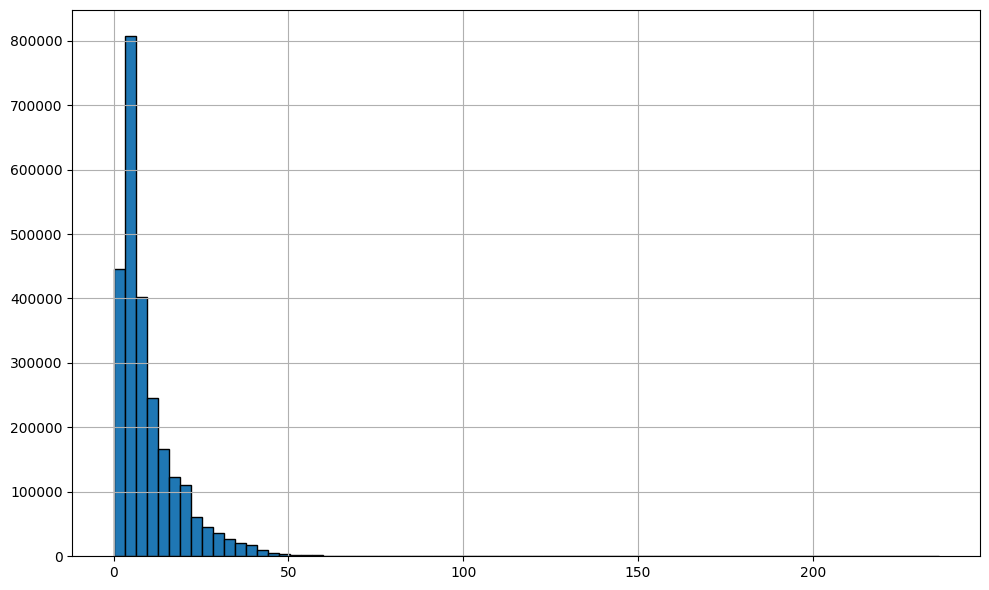

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=75, edgecolor='black')
# plt.title("Distribution of String Lengths in IMK master")
# plt.xlabel("String Length")
# plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
np.mean(lengths)

np.float64(9.944282097928435)

# Build Index


### tree_num=2


In [2]:
data = pd.read_csv('Data/IMK_한글품명.txt', delimiter='\t', dtype=str)
# data = pd.read_csv('Data/IMK_master.txt', delimiter='\t', dtype=str)
# data = pd.read_csv('Data/Random_strings_0.1K.txt', header=None)
data['label'] = data['label'].astype(str)
data['description'] = data['description'].astype(str)
data = data[:1_000_000]

In [3]:
data.head(2)

,label,description
0,1000000800,파리채
1,1000002100,살충제


In [4]:
print(len(data))

1000000


In [5]:
%%time

# Create and configure index
leven_index = LevenshteinIndex(num_trees=2, n_jobs=20)

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
%%time

# Add strings in bulk
leven_index.add_items_bulk(data['description'])

# v
# CPU times: total: 219 ms
# Wall time: 214 ms

CPU times: total: 219 ms
Wall time: 212 ms


In [ ]:
%%time

# Build index
leven_index.build()

# CPU times: total: 9min 31s
# Wall time: 9min 36s

CPU times: total: 9min 31s
Wall time: 9min 36s


In [ ]:
### old code 시간
# v3
# CPU times: total: 39min 47s
# Wall time: 40min

# v4
# 101m 까지 진행, 멈춤

# v5 
# 57m 까지 진행, 멈춤

# v6
# CPU times: total: 39min 21s
# Wall time: 39min 31s

# v7
# CPU times: total: 16h 33min 14s
# Wall time: 8h 13min 14s

In [ ]:
%%time

# save
leven_index.save("Models/LevenshteinIndex_IMK_한글품명_2tree.npz")

# for num_trees=2, len(data)~2.5M

# v3
# CPU times: total: 7.39 s
# Wall time: 7.41 s

# v4

# v6
# CPU times: total: 7.39 s
# Wall time: 7.45 s

# v7
# CPU times: total: 11.1 s
# Wall time: 11.1 s

# CPU times: total: 1.34 s
# Wall time: 1.36 s

CPU times: total: 1.34 s
Wall time: 1.36 s


In [9]:
%%time

# Query
query = data['description'][5]
neighbors = leven_index.get_nns_by_string(query, topk=5)

print("Query:", query)
print("Top 5 nearest neighbors:")
for idx in neighbors:
    if idx is not None:
        print(f"{idx}, {leven_index.get_strings()[idx]}")

# for num_trees=2, len(data)~2.5M
# 2.5M 데이터에서 top5 유사품목 1번 검색하는데 걸리는 시간

# v3
# CPU times: total: 0 ns
# Wall time: 1 ms

# v4

# v6
# Query: F Killer 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
# CPU times: total: 0 ns
# Wall time: 0 ns

# v7 
# Query: F Killer 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
# CPU times: total: 15.6 ms
# Wall time: 15.7 ms

Query: 에프킬라
Top 5 nearest neighbors:
CPU times: total: 0 ns
Wall time: 997 μs


### tree_num=10


In [11]:
data = pd.read_csv('Data/IMK_한글품명.txt', delimiter='\t', dtype=str)
data['label'] = data['label'].astype(str)
data['description'] = data['description'].astype(str)

In [12]:
data.head(2)

,label,description
0,1000000800,파리채
1,1000002100,살충제


In [13]:
print(len(data))

2538466


In [14]:
%%time

# Create and configure index
leven_index = LevenshteinIndex(num_trees=10, n_jobs=20)


# for num_trees=10, len(data)~2.5M

# v3
# CPU times: total: 0 ns
# Wall time: 2.99 ms

# v4

# v6
# CPU times: total: 469 ms
# Wall time: 490 ms

CPU times: total: 0 ns
Wall time: 0 ns


In [15]:
%%time

# Add strings in bulk
leven_index.add_items_bulk(data['description'])

# for num_trees=10, len(data)~2.5M

# v3
# CPU times: total: 4.39 s
# Wall time: 4.42 s

# v4

# v6
# CPU times: total: 1.14 s
# Wall time: 1.15 s

CPU times: total: 562 ms
Wall time: 536 ms


In [ ]:
%%time

# Build index
leven_index.build()

# for num_trees=10, len(data)~2.5M

# v3
# CPU times: total: 3h 13min 4s
# Wall time: 3h 13min 19s

# v4

# v6
# CPU times: total: 3h 18min 12s
# Wall time: 3h 17min 16s

In [ ]:
%%time

# save
leven_index.save("Models/LevenshteinIndex_IMK_한글품명_10tree.npz")

# for num_trees=10, len(data)~2.5M

# v3
# CPU times: total: 36.6 s
# Wall time: 36.7 s

# v4

# v6
# CPU times: total: 36.5 s
# Wall time: 36.5 s


CPU times: total: 36.5 s
Wall time: 36.5 s


In [ ]:
query_str = '에프킬라 500ml 킨 에스씨존슨코리아'

In [ ]:
all_matches = []
for tree in leven_index.trees:
    match_idx = leven_index._query(tree, query_str)
    all_matches.append(match_idx)

In [ ]:
all_matches

[np.int32(1395689),
 np.int32(632816),
 np.int32(2446750),
 np.int32(292474),
 np.int32(405560),
 np.int32(392650),
 np.int32(966375),
 np.int32(595007),
 np.int32(1781985),
 np.int32(356551)]

In [ ]:
%%time

# Query
# query = data['description'][5]
query = '에프킬라 500ml 킨 에스씨존슨코리아'
indices, distances = leven_index.get_nns_by_string(query, topk=5, include_distances=True)

print("Query:", query)
print("Top 5 nearest neighbors:")
for idx, dist in zip(indices, distances):
    if idx is not None:
        print(f"{idx}, {leven_index.get_strings()[idx]}, dist: {dist}")

# for num_trees=10, len(data)~2.5M
# 2.5M 데이터에서 top5 유사품목 1번 검색하는데 걸리는 시간

# v3
# Query: 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 1914772, 8T x 500mm 300mm 제작품, dist: 15
# 1209213, 리벳 못 4.0mm x 11, dist: 16
# 386400, 삼성T 5호 고무호스 해수펌프용, dist: 17
# 1812221, 엠프 PA 1500TC 최대출력 200W, dist: 17
# 754793, 에어원형 흡입샌더 UD 1638 UDT, dist: 18
# CPU times: total: 0 ns
# Wall time: 2 ms

# v4

# v6
# Query: 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 1781985, 안전닛블 PH500x 3 4 STEEL, dist: 17
# 966375, 리데나 50 x 70 10 NBR, dist: 17
# 632816, Hand Cream 핸드크림 존슨앤존슨, dist: 17
# 292474, 와이어 65mm x 18M 시브용, dist: 17
# 595007, 유니온패킹 비석면 40A 명인코리아, dist: 17
# CPU times: total: 0 ns
# Wall time: 1e+03 μs

Query: 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
1781985, 안전닛블 PH500x 3 4 STEEL, dist: 17
966375, 리데나 50 x 70 10 NBR, dist: 17
632816, Hand Cream 핸드크림 존슨앤존슨, dist: 17
292474, 와이어 65mm x 18M 시브용, dist: 17
595007, 유니온패킹 비석면 40A 명인코리아, dist: 17
CPU times: total: 0 ns
Wall time: 1e+03 μs


### tree_num = 100


In [ ]:
data = pd.read_csv('Data/IMK_한글품명.txt', delimiter='\t', dtype=str)
data['label'] = data['label'].astype(str)
data['description'] = data['description'].astype(str)

In [ ]:
data.head(2)

,label,description
0,1000000800,Fly Swatter 파리채 L520mm
1,1000002100,Insecticide 살충제 500ml 수성에어졸 무향 파리 모기등의살충제 안전기준...


In [ ]:
print(len(data))

2538466


In [ ]:
%%time

# Create index 
leven_index = LevenshteinIndex(num_trees=100, n_jobs=20)


# for num_trees=100, len(data)~2.5M

# v3
# CPU times: total: 500 ms
# Wall time: 505 ms

# v4

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time

# add data
leven_index.add_items_bulk(data['description'])

# for num_trees=100, len(data)~2.5M

# v3
# CPU times: total: 1.2 s
# Wall time: 1.17 s

# v4

CPU times: total: 1.16 s
Wall time: 1.16 s


In [ ]:
%%time

# build index
leven_index.build()

# for num_trees=100, len(data)~2.5M
# v3

# v4

# v5

# v6
# CPU times: total: 1d 9h 5min 51s
# Wall time: 1d 8h 57min 3s

# v7


CPU times: total: 1d 9h 5min 51s
Wall time: 1d 8h 57min 3s


In [ ]:
%%time

# save
leven_index.save("Models/LevenshteinIndex_IMK_한글품명_100tree.npz")

# for num_trees=100, len(data)~2.5M

# v3

# v4

# v5

# v6
# CPU times: total: 6min 6s
# Wall time: 6min 6s

CPU times: total: 6min 6s
Wall time: 6min 6s


In [ ]:
%%time

# Query
# query = data['description'][5]
query = '에프킬라 500ml 킨 에스씨존슨코리아'
indices, distances = leven_index.get_nns_by_string(query, topk=5, include_distances=True)

print("Query:", query)
print("Top 5 nearest neighbors:")
for idx, dist in zip(indices, distances):
    if idx is not None:
        print(f"{idx}, {leven_index.get_strings()[idx]}, dist: {dist}")

# for num_trees=100, len(data)~2.5M

# v3

# v4

# v6
# Query: 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 703003, 에어니플 300S 3 8 수놈, dist: 15
# 719043, 에어건 600L 돼지꼬리, dist: 15
# 305947, 갭스펀지 100mm x 80mm 2m, dist: 15
# 2074991, LCDO 100 소방호스건조기 켐코리아, dist: 15
# 1255974, 유리세정제 600ml 원폴리머 파워글라스, dist: 16
# CPU times: total: 15.6 ms
# Wall time: 12 ms

Query: 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
703003, 에어니플 300S 3 8 수놈, dist: 15
719043, 에어건 600L 돼지꼬리, dist: 15
305947, 갭스펀지 100mm x 80mm 2m, dist: 15
2074991, LCDO 100 소방호스건조기 켐코리아, dist: 15
1255974, 유리세정제 600ml 원폴리머 파워글라스, dist: 16
CPU times: total: 15.6 ms
Wall time: 12 ms


In [ ]:
leven_index=None

# Search ALL


In [ ]:
from rapidfuzz.distance import Levenshtein
import unicodedata
from rapidfuzz import fuzz

# 이거 성능 뒤지게 구림
# Korean Decomposition function using unicodedata
def decompose_korean(text, *args, **kwargs):
    decomposed = ''
    for char in text:
        if '가' <= char <= '힣':
            # Korean syllables range: decompose
            decomposed += unicodedata.normalize('NFD', char)
        else:
            decomposed += char
    return decomposed

In [ ]:
%%time

# query = data['description'][5]
query = '에프킬라 500ml 킨 에스씨존슨코리아'

# Add a new column with fuzz.ratio distances to the query string
# data['sim'] = data['description'].map(lambda x: fuzz.ratio(query, x, processor=decompose_hangul))
data['sim'] = data['description'].map(lambda x: fuzz.ratio(query, x))


# Sort and take top 5
top5 = data.sort_values('sim', ascending=False).head(5)  # Higher ratio = more similar

# Display
print("Query:", query)
print("Top 5 nearest neighbors:")
for _, row in top5.iterrows():
    print(f"{row.name}, {row['description']}")
# 2.5M 데이터에서 top5 유사품목 1번 검색하는데 걸리는 시간


# Query: 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
# 761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
# 478288, F Killer 에프킬라 500ml 안전기준 확인 에스씨존슨코리아
# 1686149, F Killer 에프킬라 500ml 내추럴 후레쉬 오렌지향 에스씨존슨코리아
# 2165105, 에프킬라 킨 500ml 제작품

# CPU times: total: 1.67 s
# Wall time: 1.67 s

Query: 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
478288, F Killer 에프킬라 500ml 안전기준 확인 에스씨존슨코리아
1686149, F Killer 에프킬라 500ml 내추럴 후레쉬 오렌지향 에스씨존슨코리아
2165105, 에프킬라 킨 500ml 제작품
CPU times: total: 1.67 s
Wall time: 1.67 s


In [ ]:
%%time

# query = data['description'][5]
query = '에프킬라 500ml 킨 에스씨존슨코리아'

# Add a new column with fuzz.ratio distances to the query string
data['sim'] = data['description'].astype(str).map(lambda x: Levenshtein.distance(query, x))


# Sort and take top 5
top5 = data.sort_values('sim', ascending=True).head(5)  # Small score = more similar

# Display
print("Query:", query)
print("Top 5 nearest neighbors:")
for _, row in top5.iterrows():
    print(f"{row.name}, {row['description']}")

# 2.5M 데이터에서 top5 유사품목 1번 검색하는데 걸리는 시간

# Query: 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
# 761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
# 1287549, 에프킬라 500mlx24 제작품
# 2165105, 에프킬라 킨 500ml 제작품
# 45248, 에어로젤 2roll 세트 에어로젤코리아

# CPU times: total: 1.62 s
# Wall time: 1.61 s

Query: 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
1287549, 에프킬라 500mlx24 제작품
2165105, 에프킬라 킨 500ml 제작품
45248, 에어로젤 2roll 세트 에어로젤코리아
CPU times: total: 1.62 s
Wall time: 1.61 s


In [ ]:
%%time

# query = data['description'][5]
query = '에프킬라 500ml 킨 에스씨존슨코리아'

# Add a new column with fuzz.ratio distances to the query string
data['sim'] = data['description'].astype(str).map(lambda x: Levenshtein.distance(query, x, weights=(1,1,10)))


# Sort and take top 5
top5 = data.sort_values('sim', ascending=True).head(5)  # Small score = more similar

# Display
print("Query:", query)
print("Top 5 nearest neighbors:")
for _, row in top5.iterrows():
    print(f"{row.name}, {row['description']}")

# 2.5M 데이터에서 top5 유사품목 1번 검색하는데 걸리는 시간

# Query: 에프킬라 500ml 킨 에스씨존슨코리아
# Top 5 nearest neighbors:
# 5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
# 761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
# 2165105, 에프킬라 킨 500ml 제작품
# 1287549, 에프킬라 500mlx24 제작품
# 976072, 아킬라 400ml

# CPU times: total: 1.64 s
# Wall time: 1.64 s

Query: 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
2165105, 에프킬라 킨 500ml 제작품
1287549, 에프킬라 500mlx24 제작품
976072, 아킬라 400ml
CPU times: total: 1.64 s
Wall time: 1.64 s
